In [1]:
# import mod
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-12-05 09:32:20.797615: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 09:32:21.118627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 09:32:21.118698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 09:32:21.176865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 09:32:21.292946: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 09:32:21.295066: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# dataframe 불러오기
poke_data = pd.read_csv("./pokemon/pokemon.csv")

# 데이터 확인
poke_data.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [3]:
# 전체 갯수 확인
poke_data.count()

Name     809
Type1    809
Type2    405
dtype: int64

In [4]:
# 결측치 확인
poke_data.isnull().sum()

Name       0
Type1      0
Type2    404
dtype: int64

In [5]:
#이미지 불러오기
img_path = "./pokemon/images/images/"
file_list = os.listdir(img_path)

# path 에서 이름 나누고
jpg_names = [os.path.split(x)[1] for x in file_list]

# 나눈 이름 중, png와 jpg 제거해 준다. (이름만을 따기 위함)
poke_names = list(map(lambda x: x.replace('.png', ''), jpg_names))
poke_names = list(map(lambda x: x.replace('.jpg', ''), poke_names))

In [6]:
#나눈 이름 : 경로 가지고 df 생성
img_data = pd.DataFrame(data=[poke_names, list(map(lambda x: img_path + x, jpg_names))]) 

# transpose로 col 맞추어 주고
img_data = img_data.T

# 이름 변경
img_data = img_data.rename(columns={0 : "Name", 1 : "Path"})

In [7]:
# merge 시켜서 총 데이터 생성
matched_data = poke_data.merge(img_data, on="Name")

# Type2는 빈 값이 너무 많아 삭제 후
matched_data = matched_data.drop(columns=['Type2'])

# 데이터 확인
matched_data

,Name,Type1,Path
0,bulbasaur,Grass,./pokemon/images/images/bulbasaur.png
1,ivysaur,Grass,./pokemon/images/images/ivysaur.png
2,venusaur,Grass,./pokemon/images/images/venusaur.png
3,charmander,Fire,./pokemon/images/images/charmander.png
4,charmeleon,Fire,./pokemon/images/images/charmeleon.png
...,...,...,...
804,stakataka,Rock,./pokemon/images/images/stakataka.jpg
805,blacephalon,Fire,./pokemon/images/images/blacephalon.jpg
806,zeraora,Electric,./pokemon/images/images/zeraora.jpg
807,meltan,Steel,./pokemon/images/images/meltan.jpg


In [8]:
# 데이터 전처리, 분할, flip으로 이미지 데이터 보강
generator = ImageDataGenerator(rescale=1./255, validation_split=0.3, horizontal_flip=True)

In [9]:
# Train 데이터 데이터프레임 iter 생성
train_generator = generator.flow_from_dataframe(
    dataframe=matched_data,
    x_col="Path",
    y_col="Type1",
    subset="training",
    color_mode='rgba',
    batch_size=32,
    seed=42,
    shuffle=True,
    target_size=(150, 150) # 이미지 크기 조정
)


Found 567 validated image filenames belonging to 18 classes.


In [10]:
# Test 데이터 데이터프레임 iter 생성
validation_generator = generator.flow_from_dataframe(
    dataframe=matched_data,
    x_col="Path",
    y_col="Type1",
    subset="validation",
    color_mode='rgba',
    batch_size=32,
    seed=42,
    shuffle=True,
    target_size=(150, 150) # 이미지 크기 조정
)

Found 242 validated image filenames belonging to 18 classes.


In [11]:
model = tf.keras.Sequential([
    # 150 x 150 크기의 이미 넣고 채널 늘린다. 활성화 함수 -> Relu
    tf.keras.layers.Conv2D(64, (8, 8), activation='relu', input_shape=(150, 150, 4)),
    # 이미지 버퍼의 특징 추출
    tf.keras.layers.MaxPooling2D(2, 2),
    # 과적합 방지 위한 임의 노드 제외
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, (8, 8), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    
    # 분류를 위한 1차원화
    tf.keras.layers.Flatten(),
    # 분류 Dense
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(18, activation='softmax')
])

2023-12-05 09:32:25.965011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 09:32:25.965363: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-12-05 09:32:26.039496: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-12-05 09:32:26.106769: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-12-05 09:32:26.702662: W external/local_tsl/tsl/framework/cpu_allocator_

In [12]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
result = model.fit(train_generator, epochs=15, validation_data=validation_generator)

# 모델 평가
loss, accuracy = model.evaluate(validation_generator)

Epoch 1/15


2023-12-05 09:32:27.669400: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-12-05 09:32:27.700203: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


18/18 [==============================] - 41s 2s/step - loss: 9.9157 - accuracy: 0.0811 - val_loss: 3.0619 - val_accuracy: 0.0579
Epoch 2/15
18/18 [==============================] - 38s 2s/step - loss: 2.8927 - accuracy: 0.1199 - val_loss: 2.9722 - val_accuracy: 0.0661
Epoch 3/15
18/18 [==============================] - 38s 2s/step - loss: 2.6690 - accuracy: 0.1693 - val_loss: 2.9697 - val_accuracy: 0.0579
Epoch 4/15
18/18 [==============================] - 39s 2s/step - loss: 2.4725 - accuracy: 0.2257 - val_loss: 2.7616 - val_accuracy: 0.1240
Epoch 5/15
18/18 [==============================] - 39s 2s/step - loss: 2.2720 - accuracy: 0.2769 - val_loss: 2.8268 - val_accuracy: 0.1281
Epoch 6/15
18/18 [==============================] - 38s 2s/step - loss: 2.1303 - accuracy: 0.3333 - val_loss: 2.8017 - val_accuracy: 0.0744
Epoch 7/15
18/18 [==============================] - 39s 2s/step - loss: 1.9704 - accuracy: 0.3880 - val_loss: 2.7797 - val_accuracy: 0.1364
Epoch 8/15
18/18 [=============

In [13]:
# epoch에 따른 결과 확인
result.history

{'loss': [9.915729522705078,
  2.8926775455474854,
  2.668992042541504,
  2.472477912902832,
  2.2719991207122803,
  2.1303043365478516,
  1.9703700542449951,
  1.7553107738494873,
  1.539512038230896,
  1.3234905004501343,
  1.2086697816848755,
  1.2167706489562988,
  1.1350678205490112,
  0.9645933508872986,
  0.8558194041252136],
 'accuracy': [0.08112874627113342,
  0.11992945522069931,
  0.16931216418743134,
  0.22574955224990845,
  0.2768959403038025,
  0.3333333432674408,
  0.3880070447921753,
  0.45679011940956116,
  0.5361552238464355,
  0.5961199402809143,
  0.6243386268615723,
  0.6437389850616455,
  0.631393313407898,
  0.6931216716766357,
  0.733686089515686],
 'val_loss': [3.0618531703948975,
  2.972163677215576,
  2.969677686691284,
  2.7616121768951416,
  2.826786994934082,
  2.801724672317505,
  2.7796995639801025,
  2.681386947631836,
  2.7397944927215576,
  2.7371654510498047,
  2.705146074295044,
  2.715322971343994,
  2.8604702949523926,
  2.6980209350585938,
  2.81

In [14]:
# 정확도 비교 설정
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

# loss값 비교 설정
loss = result.history['loss']
val_loss = result.history['val_loss']

# x축 -> epochs 돌린 수
epochs = range(len(acc))

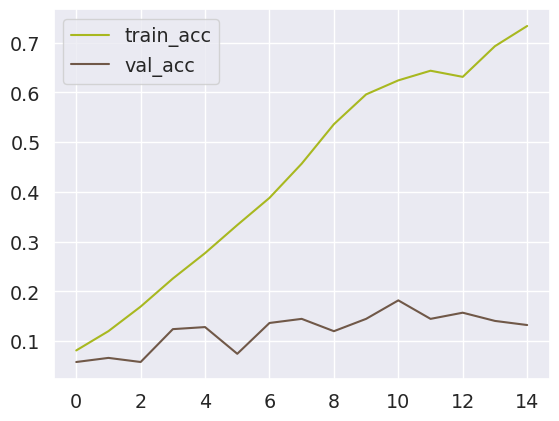

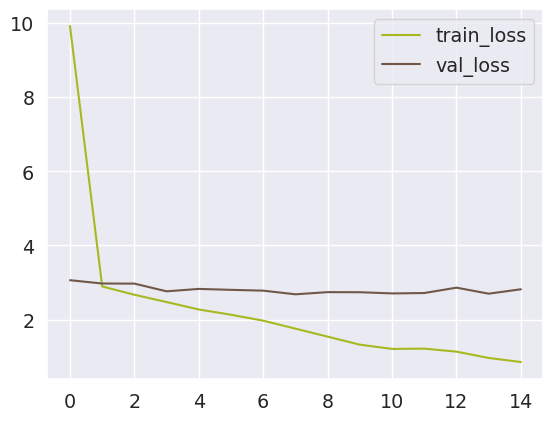

In [51]:
# legend label 삽입
plt.plot(epochs, acc, label='train_acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

# 새 그래프 생성
plt.figure()

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()

In [45]:
# 정답 라벨
true_labels = validation_generator.labels

In [46]:
# 모델 예측치 생성
predictions = model.predict(validation_generator)

8/8 [==============================] - 2s 260ms/step


In [91]:
# 예측치 라벨 배열
predict_labels = []

max_idx = -1
max_val = -1

# 확률값의 최대치 idx를 판단한 정답이라고 보고 idx 넣는다.
for i in range(0,predictions.__len__()):
    for j in range(0,predictions[i].__len__()):
        if max_val < predictions[i][j]:
            max_val = predictions[i][j]
            max_idx = j

    predict_labels.append(max_idx)
    max_val = -1
    max_idx = -1

In [95]:
# 타입을 맞춘 수 들어갈 배열
cur_types = [0 for _ in range(0,18)]

# 실제 타입의 이름
type_list = list(matched_data['Type1'].unique())

# 타입을 맞추면 ? -> 그 타입에 상응하는 idx에 값을 넣는다.
for i in range(0,predict_labels.__len__()):
    if true_labels[i] == predict_labels[i]:
        cur_types[true_labels[i]] += 1

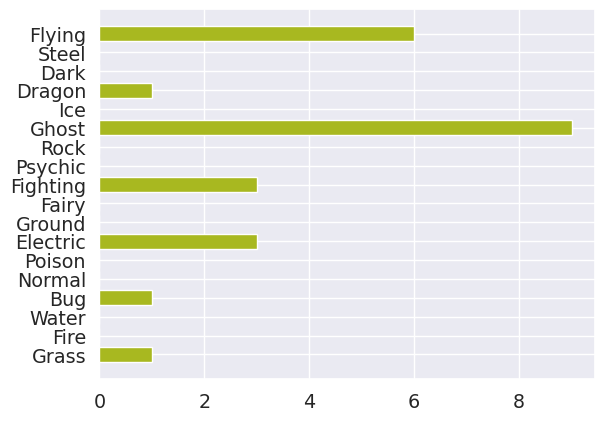

In [96]:
import numpy as np

# Bar 형식의 그래프 생성
plt.barh(type_list, cur_types)

plt.show()